In [8]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('../../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Experiments

Here we showcase 3 types of experiments:

* **Hyperparameter optimization** for training of a model (*using Optuna*) **[not ready yet]**

* **Adversarial Training** of a model for different hyperparameters

* Evaluation of **Adversarial Attacks**


Preconditions:

* you need a ***PL-Module*** that specifies your model class and dataset!

# Training of a Model

* define your hyperparameters in `hparams`
* create your instance of `PLModule`
* define a trainer (e.g., define max epochs, ...)
* fit your model!

In [9]:
import numpy as np
import torch
import pytorch_lightning as pl
from pytorch_lightning import loggers
import config

In [10]:
from classification.models.M5 import M5, M5PLModule

hparams = {
    "batch_size": 64,
    "learning_rate": 3e-4,
    "weight_decay": 0.001,
    "lr_decay": 0.95
}

model = M5PLModule(hparams)
model.prepare_data()

Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


In [22]:
trainer = pl.Trainer(
    max_epochs = 20,
    logger = loggers.TensorBoardLogger(config.LOG_DIR, name="M5"),
    gpus = 1 if torch.cuda.is_available() else None,
    log_gpu_memory = 'all'
)

trainer.fit(model)
model.save("./" + str(int(time.time())) + ".p")

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]


Saved model to "./1592000682.p"


# II: Adversarial Training

* same as normal training, but call **`model.setAttack`** 

In [170]:
from attacks.pgd import ProjectedGradientDescent 

attack_args = [{"norm": "inf", "epsilon": {"SAMPLING_MODE": "log", "l": 1e-4, "u": 0.1 } },
                {"norm": "inf", "epsilon": {"SAMPLING_MODE": "log", "l": 1e-4, "u": 0.2 } },
                {"norm": "inf", "epsilon": {"SAMPLING_MODE": "log", "l": 1e-4, "u": 0.5 } },
                {"norm": "inf", "epsilon": {"SAMPLING_MODE": "log", "l": 0.1, "u": 0.2 } },
                {"norm": "inf", "epsilon": {"SAMPLING_MODE": "log", "l": 0.1, "u": 0.5 } },
                {"norm": "inf", "epsilon": 0.1 },
                {"norm": "inf", "epsilon": 0.2 },
                {"norm": "inf", "epsilon": 0.5 },

                {"norm": "1", "epsilon": {"SAMPLING_MODE": "log", "l": 1, "u": 5000 } },
                {"norm": "1", "epsilon": {"SAMPLING_MODE": "log", "l": 1, "u": 10000 } },
                {"norm": "1", "epsilon": {"SAMPLING_MODE": "log", "l": 1, "u": 20000 } },
                {"norm": "1", "epsilon": {"SAMPLING_MODE": "log", "l": 5000, "u": 10000 } },
                {"norm": "1", "epsilon": {"SAMPLING_MODE": "log", "l": 5000, "u": 20000 } },
                {"norm": "1", "epsilon": 5000 },
                {"norm": "1", "epsilon": 10000 },
                {"norm": "1", "epsilon": 20000 },
              
                {"norm": "2", "epsilon": {"SAMPLING_MODE": "log", "l": 0.001, "u": 20 } },
                {"norm": "2", "epsilon": {"SAMPLING_MODE": "log", "l": 0.001, "u": 50 } },
                {"norm": "2", "epsilon": {"SAMPLING_MODE": "log", "l": 0.001, "u": 100 } },
                {"norm": "2", "epsilon": {"SAMPLING_MODE": "log", "l": 10, "u": 50 } },
                {"norm": "2", "epsilon": {"SAMPLING_MODE": "log", "l": 20, "u": 100 } },
                {"norm": "2", "epsilon": 20 },
                {"norm": "2", "epsilon": 50 },
                {"norm": "2", "epsilon": 100 }]
              

prefix = str(int(time.time()))


def adv_train(attack_args):
    for i in range(len(attack_args)):
        model = M5PLModule(hparams)
        model.prepare_data()
        model.setAttack(ProjectedGradientDescent, attack_args[i])
        
        prefix = "trial#{}_l{}".format(i, attack_args[i]["norm"])

        trainer = pl.Trainer(
            max_epochs=50,
            logger= loggers.TensorBoardLogger(config.LOG_DIR, name="M5"),
            gpus=1 if torch.cuda.is_available() else None,
            log_gpu_memory='all'
        )
        trainer.fit(model)
        model.save("./adv_training_results/" + prefix + "_adv.p")

adv_train(attack_args)

Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)


Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


Set SLURM handle signals.

   | Name           | Type         | Params
--------------------------------------------
0  | model          | M5           | 555 K 
1  | model.model    | Sequential   | 555 K 
2  | model.model.0  | Conv1d       | 10 K  
3  | model.model.1  | BatchNorm1d  | 256   
4  | model.model.2  | MaxPool1d    | 0     
5  | model.model.3  | Dropout      | 0     
6  | model.model.4  | Conv1d       | 49 K  
7  | model.model.5  | BatchNorm1d  | 256   
8  | model.model.6  | MaxPool1d    | 0     
9  | model.model.7  | Dropout      | 0     
10 | model.model.8  | Conv1d       | 98 K  
11 | model.model.9  | BatchNorm1d  | 512   
12 | model.model.10 | MaxPool1d    | 0     
13 | model.model.11 | Dropout      | 0     
14 | model.model.12 | Conv1d       | 393 K 
15 | model.model.13 | BatchNorm1d  | 1 K   
16 | model.model.14 | MaxPool1d    | 0     
17 | model.model.15 | AvgPool1d    | 0     
18 | model.model.16 | PermuteLayer | 0     
19 | model.model.17 | Linear       | 1 K   
/nfs

Val-Acc=0.03852993479549496


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.8091286307053942


Val-Acc=0.8132780082987552


Val-Acc=0.7806757557794902


Val-Acc=0.8215767634854771


Val-Acc=0.8186129223473622


Val-Acc=0.8186129223473622


Val-Acc=0.8269116775340841


Val-Acc=0.8310610551274452


Val-Acc=0.8103141671606402


Val-Acc=0.8103141671606402


Val-Acc=0.8292827504445762


Val-Acc=0.8186129223473622


Val-Acc=0.8233550681683461


Val-Acc=0.8263189093064611


Val-Acc=0.8286899822169532


Val-Acc=0.8316538233550682


Val-Acc=0.8203912270302312


Val-Acc=0.8304682868998222


Val-Acc=0.8286899822169532


Val-Acc=0.8168346176644932


Val-Acc=0.8280972139893301


Val-Acc=0.8363959691760522


Val-Acc=0.8292827504445762


Val-Acc=0.8316538233550682


Val-Acc=0.8423236514522822


Val-Acc=0.8203912270302312


Val-Acc=0.8340248962655602


Val-Acc=0.8138707765263782


Val-Acc=0.8286899822169532


Val-Acc=0.8316538233550682


Val-Acc=0.8381742738589212


Val-Acc=0.8316538233550682


Val-Acc=0.8399525785417902


Val-Acc=0.8363959691760522


Val-Acc=0.8405453467694132


Val-Acc=0.8405453467694132


Val-Acc=0.8387670420865442


Val-Acc=0.8369887374036752


Val-Acc=0.8292827504445762


Val-Acc=0.8417308832246592


Val-Acc=0.8405453467694132


Val-Acc=0.8292827504445762


Val-Acc=0.8369887374036752


Val-Acc=0.8405453467694132


Val-Acc=0.8446947243627742


Val-Acc=0.8304682868998222


Val-Acc=0.8387670420865442


Val-Acc=0.8423236514522822


Val-Acc=0.8411381149970362


Val-Acc=0.8150563129816242

Saved model to "./adv_training_results/trial#0_linf_adv.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)


Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


Set SLURM handle signals.

   | Name           | Type         | Params
--------------------------------------------
0  | model          | M5           | 555 K 
1  | model.model    | Sequential   | 555 K 
2  | model.model.0  | Conv1d       | 10 K  
3  | model.model.1  | BatchNorm1d  | 256   
4  | model.model.2  | MaxPool1d    | 0     
5  | model.model.3  | Dropout      | 0     
6  | model.model.4  | Conv1d       | 49 K  
7  | model.model.5  | BatchNorm1d  | 256   
8  | model.model.6  | MaxPool1d    | 0     
9  | model.model.7  | Dropout      | 0     
10 | model.model.8  | Conv1d       | 98 K  
11 | model.model.9  | BatchNorm1d  | 512   
12 | model.model.10 | MaxPool1d    | 0     
13 | model.model.11 | Dropout      | 0     
14 | model.model.12 | Conv1d       | 393 K 
15 | model.model.13 | BatchNorm1d  | 1 K   
16 | model.model.14 | MaxPool1d    | 0     
17 | model.model.15 | AvgPool1d    | 0     
18 | model.model.16 | PermuteLayer | 0     
19 | model.model.17 | Linear       | 1 K   
/nfs

Val-Acc=0.03556609365737996


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.8049792531120332


Val-Acc=0.8126852400711322


Val-Acc=0.8203912270302312


Val-Acc=0.8091286307053942


Val-Acc=0.8203912270302312


Val-Acc=0.8346176644931832


Val-Acc=0.8180201541197392


Val-Acc=0.8257261410788381


Val-Acc=0.8263189093064611


Val-Acc=0.8180201541197392


Val-Acc=0.8197984588026082


Val-Acc=0.7877889745109662


Val-Acc=0.8180201541197392


Val-Acc=0.8144635447540012


Val-Acc=0.8109069353882632


Val-Acc=0.8286899822169532


Val-Acc=0.8126852400711322


Val-Acc=0.8144635447540012


Val-Acc=0.8263189093064611


Val-Acc=0.8328393598103142


Val-Acc=0.8298755186721992


Val-Acc=0.7788974510966212


Val-Acc=0.8280972139893301


Val-Acc=0.8292827504445762


Val-Acc=0.8352104327208062


Val-Acc=0.8340248962655602


Val-Acc=0.8452874925903971


Val-Acc=0.7996443390634262


Val-Acc=0.8381742738589212


Val-Acc=0.8298755186721992


Val-Acc=0.8275044457617071


Val-Acc=0.8411381149970362


Val-Acc=0.8251333728512151


Val-Acc=0.8340248962655602


Val-Acc=0.8174273858921162


Val-Acc=0.8393598103141672


Val-Acc=0.8186129223473622


Val-Acc=0.8186129223473622


Val-Acc=0.8067575577949022


Val-Acc=0.8358032009484292


Val-Acc=0.7753408417308832


Val-Acc=0.8304682868998222


Val-Acc=0.8405453467694132


Val-Acc=0.8346176644931832


Val-Acc=0.8387670420865442


Val-Acc=0.8352104327208062


Val-Acc=0.8423236514522822


Val-Acc=0.8381742738589212


Val-Acc=0.8411381149970362


Val-Acc=0.8221695317131001

Saved model to "./adv_training_results/trial#1_linf_adv.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)


Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


Set SLURM handle signals.

   | Name           | Type         | Params
--------------------------------------------
0  | model          | M5           | 555 K 
1  | model.model    | Sequential   | 555 K 
2  | model.model.0  | Conv1d       | 10 K  
3  | model.model.1  | BatchNorm1d  | 256   
4  | model.model.2  | MaxPool1d    | 0     
5  | model.model.3  | Dropout      | 0     
6  | model.model.4  | Conv1d       | 49 K  
7  | model.model.5  | BatchNorm1d  | 256   
8  | model.model.6  | MaxPool1d    | 0     
9  | model.model.7  | Dropout      | 0     
10 | model.model.8  | Conv1d       | 98 K  
11 | model.model.9  | BatchNorm1d  | 512   
12 | model.model.10 | MaxPool1d    | 0     
13 | model.model.11 | Dropout      | 0     
14 | model.model.12 | Conv1d       | 393 K 
15 | model.model.13 | BatchNorm1d  | 1 K   
16 | model.model.14 | MaxPool1d    | 0     
17 | model.model.15 | AvgPool1d    | 0     
18 | model.model.16 | PermuteLayer | 0     
19 | model.model.17 | Linear       | 1 K   
/nfs

Val-Acc=0.03793716656787196


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.8049792531120332


Val-Acc=0.7925311203319502


Val-Acc=0.8120924718435092


Val-Acc=0.7907528156490812


Val-Acc=0.8150563129816242


Val-Acc=0.8233550681683461


Val-Acc=0.8322465915826912


Val-Acc=0.8109069353882632


Val-Acc=0.8138707765263782


Val-Acc=0.8269116775340841


Val-Acc=0.8233550681683461


Val-Acc=0.8067575577949022


Val-Acc=0.8085358624777712


Val-Acc=0.8109069353882632


Val-Acc=0.8132780082987552


Val-Acc=0.8144635447540012


Val-Acc=0.8316538233550682


Val-Acc=0.8340248962655602


Val-Acc=0.8239478363959691


Val-Acc=0.8156490812092472


Val-Acc=0.7972732661529343


Val-Acc=0.8239478363959691


Val-Acc=0.8340248962655602


Val-Acc=0.8227622999407231


Val-Acc=0.8061647895672792


Val-Acc=0.8186129223473622


Val-Acc=0.8233550681683461


Val-Acc=0.8257261410788381


Val-Acc=0.8203912270302312


Val-Acc=0.8203912270302312


Val-Acc=0.8251333728512151


Val-Acc=0.8387670420865442


Val-Acc=0.8197984588026082


Val-Acc=0.8109069353882632


Val-Acc=0.8144635447540012


Val-Acc=0.8085358624777712


Val-Acc=0.8037937166567872


Val-Acc=0.8369887374036752


Val-Acc=0.8251333728512151


Val-Acc=0.8144635447540012


Val-Acc=0.8245406046235921


Val-Acc=0.7682276229994073


Val-Acc=0.8114997036158862


Val-Acc=0.8393598103141672


Val-Acc=0.8156490812092472


Val-Acc=0.8269116775340841


Val-Acc=0.8245406046235921


Val-Acc=0.8233550681683461


Val-Acc=0.8417308832246592


Val-Acc=0.8043864848844102

Saved model to "./adv_training_results/trial#2_linf_adv.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)


Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


Set SLURM handle signals.

   | Name           | Type         | Params
--------------------------------------------
0  | model          | M5           | 555 K 
1  | model.model    | Sequential   | 555 K 
2  | model.model.0  | Conv1d       | 10 K  
3  | model.model.1  | BatchNorm1d  | 256   
4  | model.model.2  | MaxPool1d    | 0     
5  | model.model.3  | Dropout      | 0     
6  | model.model.4  | Conv1d       | 49 K  
7  | model.model.5  | BatchNorm1d  | 256   
8  | model.model.6  | MaxPool1d    | 0     
9  | model.model.7  | Dropout      | 0     
10 | model.model.8  | Conv1d       | 98 K  
11 | model.model.9  | BatchNorm1d  | 512   
12 | model.model.10 | MaxPool1d    | 0     
13 | model.model.11 | Dropout      | 0     
14 | model.model.12 | Conv1d       | 393 K 
15 | model.model.13 | BatchNorm1d  | 1 K   
16 | model.model.14 | MaxPool1d    | 0     
17 | model.model.15 | AvgPool1d    | 0     
18 | model.model.16 | PermuteLayer | 0     
19 | model.model.17 | Linear       | 1 K   
/nfs

/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.03852993479549496


Val-Acc=0.7854179016004742


Val-Acc=0.7966804979253111


Val-Acc=0.8073503260225252


Val-Acc=0.7854179016004742


Val-Acc=0.7978660343805573


Val-Acc=0.7996443390634262


Val-Acc=0.7729697688203913


Val-Acc=0.7705986959098993


Val-Acc=0.7866034380557202


Val-Acc=0.7385892116182573


Val-Acc=0.7759336099585062


Val-Acc=0.7202133965619443


Val-Acc=0.7700059276822763


Val-Acc=0.7652637818612922


Val-Acc=0.7664493183165383


Val-Acc=0.7457024303497333


Val-Acc=0.7800829875518672


Val-Acc=0.7338470657972732


Val-Acc=0.7237700059276823


Val-Acc=0.7077652637818613


Val-Acc=0.7190278601066983


Val-Acc=0.7089508002371073


Val-Acc=0.7225844694724363


Val-Acc=0.7611144042679312


Val-Acc=0.7759336099585062


Val-Acc=0.7628927089508002


Val-Acc=0.7966804979253111


Val-Acc=0.7540011855364552


Val-Acc=0.7605216360403082


Val-Acc=0.8061647895672792


Val-Acc=0.7954949614700652


Val-Acc=0.8138707765263782


Val-Acc=0.8049792531120332


Val-Acc=0.8197984588026082


Val-Acc=0.8150563129816242


Val-Acc=0.8227622999407231


Val-Acc=0.7895672791938352


Val-Acc=0.8109069353882632


Val-Acc=0.8120924718435092


Val-Acc=0.8073503260225252


Val-Acc=0.8109069353882632


Val-Acc=0.8209839952578541


Val-Acc=0.8310610551274452


Val-Acc=0.8180201541197392


Val-Acc=0.8215767634854771


Val-Acc=0.8192056905749852


Val-Acc=0.8209839952578541


Val-Acc=0.8346176644931832


Val-Acc=0.8280972139893301


Val-Acc=0.8275044457617071

Saved model to "./adv_training_results/trial#3_linf_adv.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)


Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


Set SLURM handle signals.

   | Name           | Type         | Params
--------------------------------------------
0  | model          | M5           | 555 K 
1  | model.model    | Sequential   | 555 K 
2  | model.model.0  | Conv1d       | 10 K  
3  | model.model.1  | BatchNorm1d  | 256   
4  | model.model.2  | MaxPool1d    | 0     
5  | model.model.3  | Dropout      | 0     
6  | model.model.4  | Conv1d       | 49 K  
7  | model.model.5  | BatchNorm1d  | 256   
8  | model.model.6  | MaxPool1d    | 0     
9  | model.model.7  | Dropout      | 0     
10 | model.model.8  | Conv1d       | 98 K  
11 | model.model.9  | BatchNorm1d  | 512   
12 | model.model.10 | MaxPool1d    | 0     
13 | model.model.11 | Dropout      | 0     
14 | model.model.12 | Conv1d       | 393 K 
15 | model.model.13 | BatchNorm1d  | 1 K   
16 | model.model.14 | MaxPool1d    | 0     
17 | model.model.15 | AvgPool1d    | 0     
18 | model.model.16 | PermuteLayer | 0     
19 | model.model.17 | Linear       | 1 K   
/nfs

Val-Acc=0.03793716656787196


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Val-Acc=0.8067575577949022


Val-Acc=0.8026081802015412


Val-Acc=0.7646710136336692


Val-Acc=0.7451096621221103


Val-Acc=0.7788974510966212


Val-Acc=0.5927682276229994


Val-Acc=0.6490812092471844


Val-Acc=0.7510373443983402


Val-Acc=0.6982809721398933


Val-Acc=0.7990515708358032


Val-Acc=0.7617071724955542


Val-Acc=0.7551867219917012


Val-Acc=0.7279193835210432


Val-Acc=0.6307053941908713


Val-Acc=0.7640782454060462


Val-Acc=0.6283343212803794


Val-Acc=0.6887966804979253


Val-Acc=0.6621221102548903


Val-Acc=0.5933609958506224


Val-Acc=0.5441612329579134


Val-Acc=0.5548310610551275


Val-Acc=0.5275637225844695


Val-Acc=0.5251926496739775


Val-Acc=0.5625370480142264


Val-Acc=0.5251926496739775


Val-Acc=0.6075874333135743


Val-Acc=0.5251926496739775


Val-Acc=0.5382335506816834


Val-Acc=0.5500889152341435


Val-Acc=0.5589804386484885


Val-Acc=0.5500889152341435


Val-Acc=0.5400118553645524


Val-Acc=0.6259632483698874


Val-Acc=0.6164789567279194


Val-Acc=0.5121517486662714


Val-Acc=0.5186721991701245


Val-Acc=0.6810906935388263


Val-Acc=0.5174866627148785


Val-Acc=0.5797273266152935


Val-Acc=0.5892116182572614


Val-Acc=0.6401896858328393


Val-Acc=0.5957320687611144


Val-Acc=0.5844694724362774


Val-Acc=0.6152934202726734


Val-Acc=0.5619442797866034


Val-Acc=0.5986959098992294


Val-Acc=0.6384113811499703


Val-Acc=0.6822762299940723


Val-Acc=0.5903971547125074


Val-Acc=0.5743924125666864

Saved model to "./adv_training_results/trial#4_linf_adv.p"
Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)


Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


Set SLURM handle signals.

   | Name           | Type         | Params
--------------------------------------------
0  | model          | M5           | 555 K 
1  | model.model    | Sequential   | 555 K 
2  | model.model.0  | Conv1d       | 10 K  
3  | model.model.1  | BatchNorm1d  | 256   
4  | model.model.2  | MaxPool1d    | 0     
5  | model.model.3  | Dropout      | 0     
6  | model.model.4  | Conv1d       | 49 K  
7  | model.model.5  | BatchNorm1d  | 256   
8  | model.model.6  | MaxPool1d    | 0     
9  | model.model.7  | Dropout      | 0     
10 | model.model.8  | Conv1d       | 98 K  
11 | model.model.9  | BatchNorm1d  | 512   
12 | model.model.10 | MaxPool1d    | 0     
13 | model.model.11 | Dropout      | 0     
14 | model.model.12 | Conv1d       | 393 K 
15 | model.model.13 | BatchNorm1d  | 1 K   
16 | model.model.14 | MaxPool1d    | 0     
17 | model.model.15 | AvgPool1d    | 0     
18 | model.model.16 | PermuteLayer | 0     
19 | model.model.17 | Linear       | 1 K   
/nfs

Val-Acc=0.03793716656787196


/nfs/homedirs/herrmanp/miniconda3/envs/ml/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


TypeError: argument of type 'float' is not iterable

# III: Robustness Evaluation

Running a single attack:

In [6]:
from attacks.pgd import ProjectedGradientDescent
attack = ProjectedGradientDescent(model.model, model.train_dataloader(), {"norm":"inf", "epsilon": 10.}, early_stopping=-1, device='cuda', save_samples=False)
attack.attack()
attack.report( )

100%|██████████| 80/80 [00:11<00:00,  7.26it/s]


Attack-Parameters:	{'norm': 'inf', 'epsilon': 10.0}
Early stopping: 	False (-1)

Successfully attacked:	4096
Total attacked: 	4096
Total processed:	5060

Success-Rate: 		1.0
Perturbed Accurracy: 	0.0


{'success_rate': 1.0}

### Documentation
* you define an experiment: an object of class `utils.RobustnessExperiment`.
    * pass a title & description for the experiment (optional)
    * pass different attacks + a list of configs, e.g.    
    
```python

exp_config = [           
              {
               "attack_fn": fast_gradient_attack, 
               "attack_arg": {"norm":["inf"], "epsilon": [0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]},
               "meta": {"key_result":"acc", "key_config":"epsilon", "title":"FGSM"}
              }
            ]
```

* all values in `attack_arg` must be in brackets. The attack will the be run for all of the values in each of the lists

* you then can **run** the experiment by passing a **model**
* the following will happen:
    * initializing of the experiment creates a folder in the dir specified in config, named ID_title. Also a pickle file will be saved to the directory.
    * if you run an attack:
        * a sub-folder in that directory will be created for the model.
        * all attacks will be ran
        * for every attack, a plot will be created
        * one json (i.e. one for each model) will be saved to the directory
        * also some samples are stored for each attack.
        
        
Workflow:

* prepare experiment config and use it to initalize experiment
* then add as many models you like
* best: run this not in notebook but as slurm job

Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/12 [00:00<?, ?it/s]

Perform Attack #1/3: FGSM


  8%|▊         | 1/12 [00:04<00:46,  4.20s/it]

Attack-Parameters:	{'norm': 'inf', 'epsilon': 0}
Early stopping: 	False (-1)

Successfully attacked:	0
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.0
Perturbed Accurracy: 	0.82


  0%|          | 0/27 [00:00<?, ?it/s].12s/it]

Attack-Parameters:	{'norm': 'inf', 'epsilon': 0.0001}
Early stopping: 	False (-1)

Successfully attacked:	0
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.0
Perturbed Accurracy: 	0.82


 25%|██▌       | 3/12 [00:11<00:36,  4.04s/it]

Attack-Parameters:	{'norm': 'inf', 'epsilon': 0.0002}
Early stopping: 	False (-1)

Successfully attacked:	0
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.0
Perturbed Accurracy: 	0.82


  0%|          | 0/27 [00:00<?, ?it/s].07s/it]

Attack-Parameters:	{'norm': 'inf', 'epsilon': 0.0005}
Early stopping: 	False (-1)

Successfully attacked:	2
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.0
Perturbed Accurracy: 	0.82


  0%|          | 0/27 [00:00<?, ?it/s].00s/it]

Attack-Parameters:	{'norm': 'inf', 'epsilon': 0.01}
Early stopping: 	False (-1)

Successfully attacked:	56
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.04
Perturbed Accurracy: 	0.79


  0%|          | 0/27 [00:00<?, ?it/s].96s/it]

Attack-Parameters:	{'norm': 'inf', 'epsilon': 0.02}
Early stopping: 	False (-1)

Successfully attacked:	103
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.07
Perturbed Accurracy: 	0.76


  0%|          | 0/27 [00:00<?, ?it/s].93s/it]

Attack-Parameters:	{'norm': 'inf', 'epsilon': 0.05}
Early stopping: 	False (-1)

Successfully attacked:	240
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.17
Perturbed Accurracy: 	0.68


  0%|          | 0/27 [00:00<?, ?it/s].91s/it]

Attack-Parameters:	{'norm': 'inf', 'epsilon': 0.1}
Early stopping: 	False (-1)

Successfully attacked:	500
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.36
Perturbed Accurracy: 	0.53


  0%|          | 0/27 [00:00<?, ?it/s].90s/it]

Attack-Parameters:	{'norm': 'inf', 'epsilon': 0.2}
Early stopping: 	False (-1)

Successfully attacked:	948
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.68
Perturbed Accurracy: 	0.26


  0%|          | 0/27 [00:00<?, ?it/s]3.90s/it]

Attack-Parameters:	{'norm': 'inf', 'epsilon': 0.5}
Early stopping: 	False (-1)

Successfully attacked:	799
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.57
Perturbed Accurracy: 	0.35


 92%|█████████▏| 11/12 [00:43<00:03,  3.89s/it]

Attack-Parameters:	{'norm': 'inf', 'epsilon': 1}
Early stopping: 	False (-1)

Successfully attacked:	773
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.56
Perturbed Accurracy: 	0.37


100%|██████████| 12/12 [00:47<00:00,  3.93s/it]


Attack-Parameters:	{'norm': 'inf', 'epsilon': 10}
Early stopping: 	False (-1)

Successfully attacked:	773
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.56
Perturbed Accurracy: 	0.37


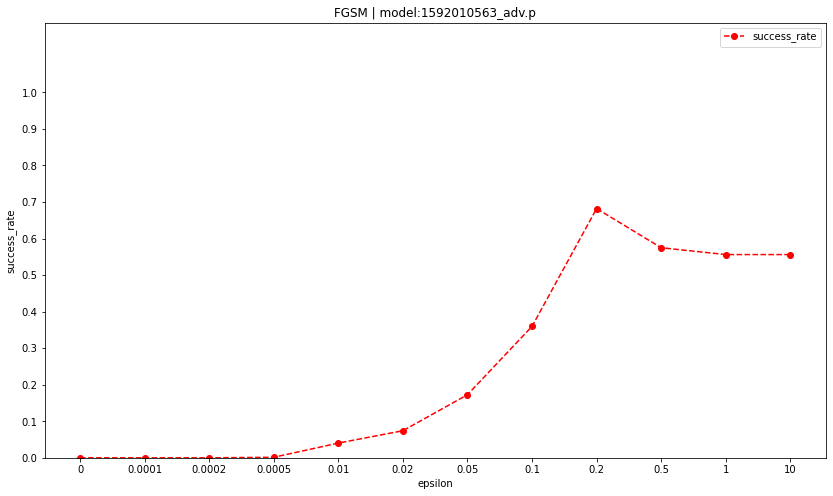

  0%|          | 0/27 [00:00<?, ?it/s]

Perform Attack #2/3: FGA L2


  0%|          | 0/27 [00:00<?, ?it/s].88s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 0}
Early stopping: 	False (-1)

Successfully attacked:	0
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.0
Perturbed Accurracy: 	0.82


  0%|          | 0/27 [00:00<?, ?it/s].89s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 1}
Early stopping: 	False (-1)

Successfully attacked:	30
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.02
Perturbed Accurracy: 	0.81


  0%|          | 0/27 [00:00<?, ?it/s].90s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 2}
Early stopping: 	False (-1)

Successfully attacked:	54
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.04
Perturbed Accurracy: 	0.79


  0%|          | 0/27 [00:00<?, ?it/s].90s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 5}
Early stopping: 	False (-1)

Successfully attacked:	118
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.08
Perturbed Accurracy: 	0.75


  0%|          | 0/27 [00:00<?, ?it/s].93s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 10}
Early stopping: 	False (-1)

Successfully attacked:	222
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.16
Perturbed Accurracy: 	0.69


 55%|█████▍    | 6/11 [00:23<00:19,  3.95s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 20}
Early stopping: 	False (-1)

Successfully attacked:	427
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.31
Perturbed Accurracy: 	0.57


  0%|          | 0/27 [00:00<?, ?it/s].98s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 50}
Early stopping: 	False (-1)

Successfully attacked:	947
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.68
Perturbed Accurracy: 	0.26


 73%|███████▎  | 8/11 [00:31<00:12,  4.05s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 100}
Early stopping: 	False (-1)

Successfully attacked:	946
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.68
Perturbed Accurracy: 	0.26


  0%|          | 0/27 [00:00<?, ?it/s].03s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 200}
Early stopping: 	False (-1)

Successfully attacked:	776
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.56
Perturbed Accurracy: 	0.36


  0%|          | 0/27 [00:00<?, ?it/s]4.09s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 500}
Early stopping: 	False (-1)

Successfully attacked:	773
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.56
Perturbed Accurracy: 	0.37


100%|██████████| 11/11 [00:44<00:00,  4.02s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 1000}
Early stopping: 	False (-1)

Successfully attacked:	773
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.56
Perturbed Accurracy: 	0.37


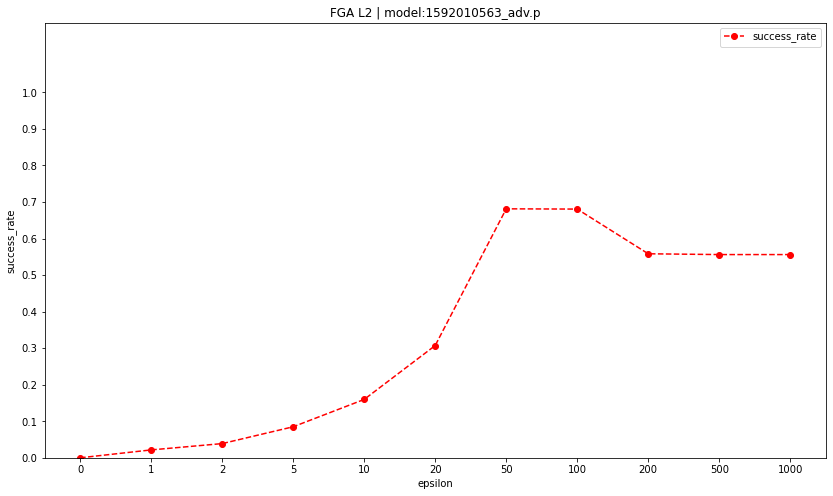

  0%|          | 0/27 [00:00<?, ?it/s]

Perform Attack #3/3: FGA L1


  0%|          | 0/27 [00:00<?, ?it/s].11s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 100}
Early stopping: 	False (-1)

Successfully attacked:	19
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.01
Perturbed Accurracy: 	0.81


  0%|          | 0/27 [00:00<?, ?it/s].05s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 200}
Early stopping: 	False (-1)

Successfully attacked:	29
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.02
Perturbed Accurracy: 	0.81


  0%|          | 0/27 [00:00<?, ?it/s].05s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 500}
Early stopping: 	False (-1)

Successfully attacked:	61
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.04
Perturbed Accurracy: 	0.79


  0%|          | 0/27 [00:00<?, ?it/s].08s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 1000}
Early stopping: 	False (-1)

Successfully attacked:	113
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.08
Perturbed Accurracy: 	0.76


  0%|          | 0/27 [00:00<?, ?it/s].10s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 2000}
Early stopping: 	False (-1)

Successfully attacked:	210
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.15
Perturbed Accurracy: 	0.7


  0%|          | 0/27 [00:00<?, ?it/s].08s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 5000}
Early stopping: 	False (-1)

Successfully attacked:	503
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.36
Perturbed Accurracy: 	0.53


  0%|          | 0/27 [00:00<?, ?it/s].08s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 10000.0}
Early stopping: 	False (-1)

Successfully attacked:	901
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.65
Perturbed Accurracy: 	0.29


 80%|████████  | 8/10 [00:32<00:08,  4.08s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 20000.0}
Early stopping: 	False (-1)

Successfully attacked:	975
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.7
Perturbed Accurracy: 	0.25


  0%|          | 0/27 [00:00<?, ?it/s].08s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 50000.0}
Early stopping: 	False (-1)

Successfully attacked:	775
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.56
Perturbed Accurracy: 	0.36


100%|██████████| 10/10 [00:40<00:00,  4.06s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 100000.0}
Early stopping: 	False (-1)

Successfully attacked:	773
Total attacked: 	1390
Total processed:	1687

Success-Rate: 		0.56
Perturbed Accurracy: 	0.37


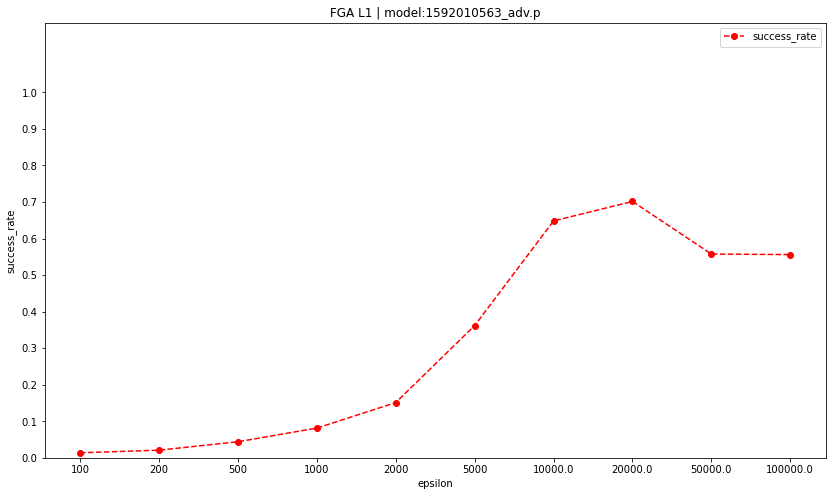

In [69]:
from utils.RobustnessExperiment import RobustnessExperiment
from attacks.FGA_Batch import fast_gradient_attack
from attacks.pgd import ProjectedGradientDescent

exp_config = [{
              "attack_fn": ProjectedGradientDescent, 
              "attack_arg": {"norm":["inf"], "epsilon": [0, 0.0001, 0.0002, 0.0005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 10]},
              "meta": {"key_result":"success_rate", "key_config":"epsilon", "title":"FGSM"}
             },
            {
            "attack_fn": ProjectedGradientDescent, 
            "attack_arg": {"norm":["2"], "epsilon": [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]},
            "meta": {"key_result":"success_rate", "key_config":"epsilon", "title":"FGA L2"}
            },
            {
            "attack_fn": ProjectedGradientDescent, 
            "attack_arg": {"norm":["1"], "epsilon": [100, 200, 500, 1000, 2000, 5000, 1e4, 2e4, 5e4, 1e5]},
            "meta": {"key_result":"success_rate", "key_config":"epsilon", "title":"FGA L1"}
            }]

experiment = RobustnessExperiment(exp_config, title="Test")
experiment.run("./1592000682.p", M5PLModule) #20 epochs normal training with hparams above
experiment.run("./1592000852_adv.p", M5PLModule) #5 epochs adv training with hparams above
experiment.run("./1592007017_adv.p", M5PLModule) #20 epochs '' L2, 15 fixed
experiment.run("./1592008146_adv.p", M5PLModule) #50 epochs '' 
experiment.run("./1592010563_adv.p", M5PLModule) # 50 epochs, L1, 5000 fixed

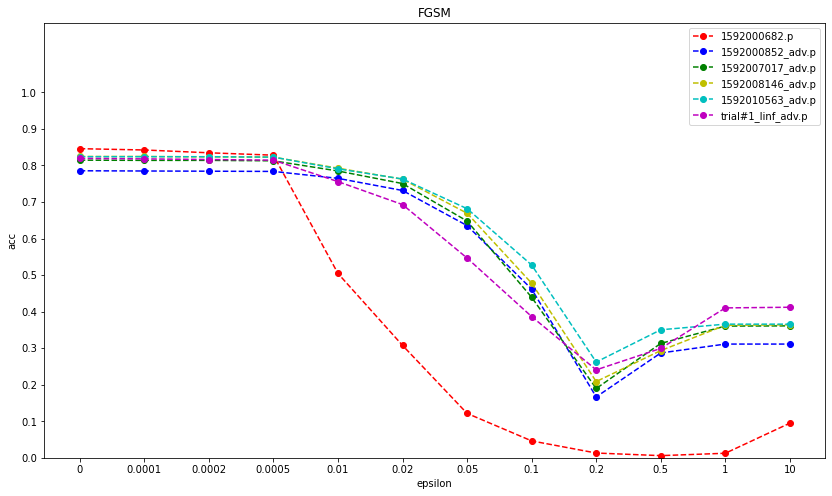

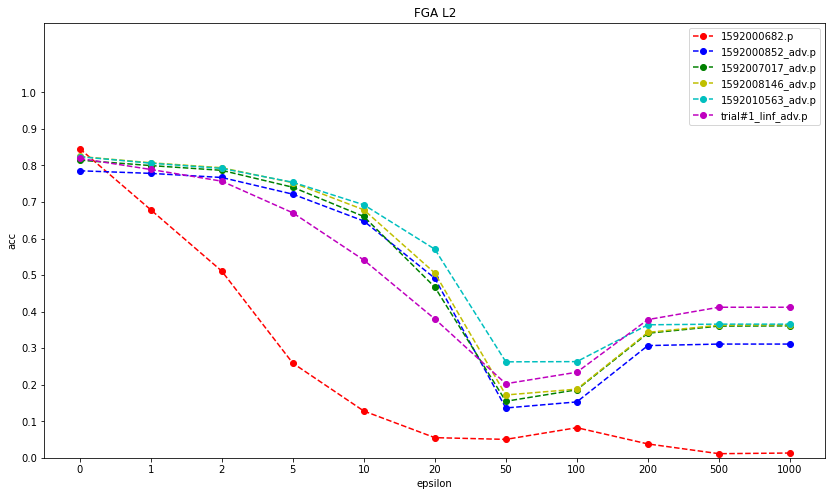

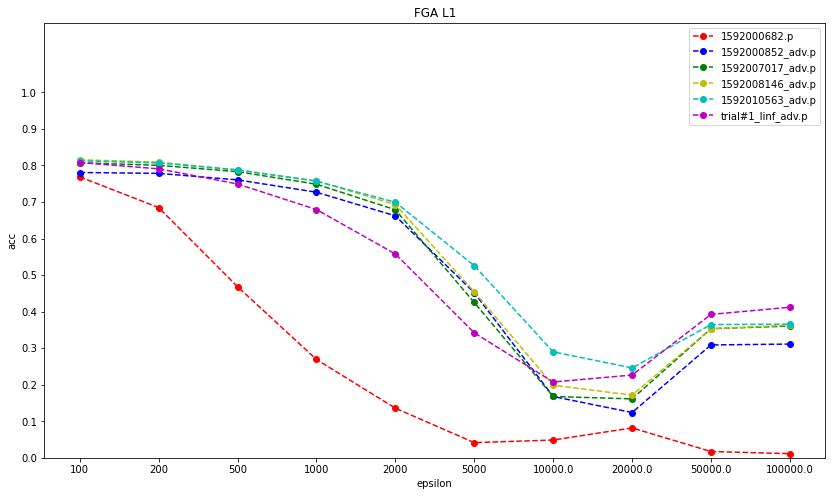

In [169]:
from utils.Visual import drawPlot

config_key = "epsilon"
results_key = "acc"

for i, attack in enumerate(experiment.all_results.keys()):
    xs = [ res[config_key] for res in experiment.all_results[attack]["CONFIGS"]] 
    vis_objects = []
    for m, model in enumerate(list(experiment.all_results[attack].keys())[1:]):
        ys = [ res[results_key] for res in experiment.all_results[attack][model]]
        vis_object = {"data": ys, "color" : "rbgycmk"[m], "label": model}
        vis_objects.append(vis_object)

    drawPlot(x = xs, data = vis_objects, x_label = config_key, y_label = results_key, 
             title = attack, 
             save_path = os.path.join(experiment.dir, "plot_comparison_{}.pdf".format(attack)))



# ToDo

* compute sum or integral of curve, evaluation of large list of models
* provide nickname for each model
* adv training:
    * sample different epochs. / do checkpoints
    * optuna: what we optimize is the accuracy on FIXED (0.001, ...) epsilon set!!!



Loading cached train data from /nfs/students/summer-term-2020/project-4/data/data_8k
Loading cached val data from /nfs/students/summer-term-2020/project-4/data/data_8k


  0%|          | 0/12 [00:00<?, ?it/s]

Perform Attack #1/3: FGSM


  0%|          | 0/27 [00:00<?, ?it/s].13s/it]

Attack-Parameters:	{'norm': 'inf', 'epsilon': 0}
Early stopping: 	False (-1)

Successfully attacked:	0
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.0
Perturbed Accurracy: 	0.82


  0%|          | 0/27 [00:00<?, ?it/s].05s/it]

Attack-Parameters:	{'norm': 'inf', 'epsilon': 0.0001}
Early stopping: 	False (-1)

Successfully attacked:	2
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.0
Perturbed Accurracy: 	0.82


 25%|██▌       | 3/12 [00:11<00:35,  3.99s/it]

Attack-Parameters:	{'norm': 'inf', 'epsilon': 0.0002}
Early stopping: 	False (-1)

Successfully attacked:	5
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.0
Perturbed Accurracy: 	0.82


  0%|          | 0/27 [00:00<?, ?it/s].02s/it]

Attack-Parameters:	{'norm': 'inf', 'epsilon': 0.0005}
Early stopping: 	False (-1)

Successfully attacked:	8
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.01
Perturbed Accurracy: 	0.81


  0%|          | 0/27 [00:00<?, ?it/s].95s/it]

Attack-Parameters:	{'norm': 'inf', 'epsilon': 0.01}
Early stopping: 	False (-1)

Successfully attacked:	107
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.08
Perturbed Accurracy: 	0.76


  0%|          | 0/27 [00:00<?, ?it/s].92s/it]

Attack-Parameters:	{'norm': 'inf', 'epsilon': 0.02}
Early stopping: 	False (-1)

Successfully attacked:	213
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.15
Perturbed Accurracy: 	0.69


  0%|          | 0/27 [00:00<?, ?it/s].91s/it]

Attack-Parameters:	{'norm': 'inf', 'epsilon': 0.05}
Early stopping: 	False (-1)

Successfully attacked:	460
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.33
Perturbed Accurracy: 	0.55


  0%|          | 0/27 [00:00<?, ?it/s].88s/it]

Attack-Parameters:	{'norm': 'inf', 'epsilon': 0.1}
Early stopping: 	False (-1)

Successfully attacked:	730
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.53
Perturbed Accurracy: 	0.39


  0%|          | 0/27 [00:00<?, ?it/s].88s/it]

Attack-Parameters:	{'norm': 'inf', 'epsilon': 0.2}
Early stopping: 	False (-1)

Successfully attacked:	976
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.71
Perturbed Accurracy: 	0.24


  0%|          | 0/27 [00:00<?, ?it/s]3.86s/it]

Attack-Parameters:	{'norm': 'inf', 'epsilon': 0.5}
Early stopping: 	False (-1)

Successfully attacked:	877
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.63
Perturbed Accurracy: 	0.3


  0%|          | 0/27 [00:00<?, ?it/s]3.85s/it]

Attack-Parameters:	{'norm': 'inf', 'epsilon': 1}
Early stopping: 	False (-1)

Successfully attacked:	690
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.5
Perturbed Accurracy: 	0.41


100%|██████████| 12/12 [00:46<00:00,  3.89s/it]


Attack-Parameters:	{'norm': 'inf', 'epsilon': 10}
Early stopping: 	False (-1)

Successfully attacked:	687
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.5
Perturbed Accurracy: 	0.41


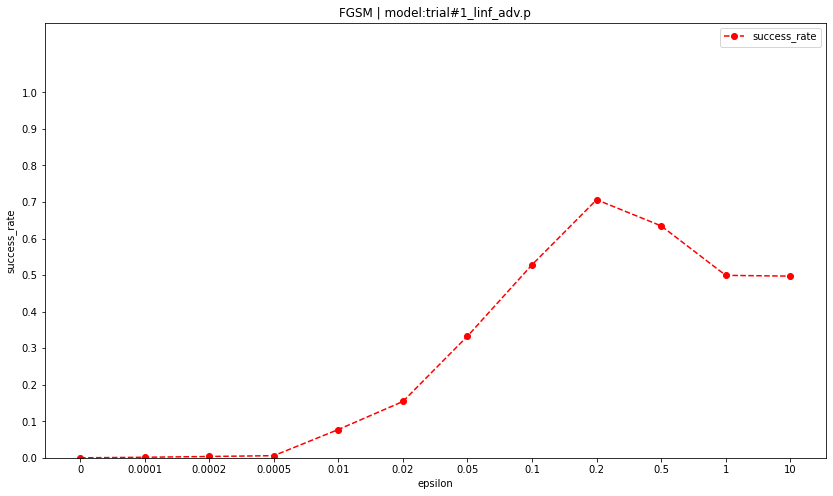

  0%|          | 0/27 [00:00<?, ?it/s]

Perform Attack #2/3: FGA L2


  0%|          | 0/27 [00:00<?, ?it/s].83s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 0}
Early stopping: 	False (-1)

Successfully attacked:	0
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.0
Perturbed Accurracy: 	0.82


  0%|          | 0/27 [00:00<?, ?it/s].85s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 1}
Early stopping: 	False (-1)

Successfully attacked:	51
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.04
Perturbed Accurracy: 	0.79


 27%|██▋       | 3/11 [00:11<00:30,  3.86s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 2}
Early stopping: 	False (-1)

Successfully attacked:	105
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.08
Perturbed Accurracy: 	0.76


  0%|          | 0/27 [00:00<?, ?it/s].90s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 5}
Early stopping: 	False (-1)

Successfully attacked:	251
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.18
Perturbed Accurracy: 	0.67


  0%|          | 0/27 [00:00<?, ?it/s].88s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 10}
Early stopping: 	False (-1)

Successfully attacked:	469
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.34
Perturbed Accurracy: 	0.54


  0%|          | 0/27 [00:00<?, ?it/s].87s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 20}
Early stopping: 	False (-1)

Successfully attacked:	741
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.54
Perturbed Accurracy: 	0.38


  0%|          | 0/27 [00:00<?, ?it/s].89s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 50}
Early stopping: 	False (-1)

Successfully attacked:	1040
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.75
Perturbed Accurracy: 	0.2


  0%|          | 0/27 [00:00<?, ?it/s].88s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 100}
Early stopping: 	False (-1)

Successfully attacked:	987
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.71
Perturbed Accurracy: 	0.23


  0%|          | 0/27 [00:00<?, ?it/s].87s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 200}
Early stopping: 	False (-1)

Successfully attacked:	744
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.54
Perturbed Accurracy: 	0.38


  0%|          | 0/27 [00:00<?, ?it/s]3.87s/it]

Attack-Parameters:	{'norm': '2', 'epsilon': 500}
Early stopping: 	False (-1)

Successfully attacked:	687
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.5
Perturbed Accurracy: 	0.41


100%|██████████| 11/11 [00:42<00:00,  3.88s/it]


Attack-Parameters:	{'norm': '2', 'epsilon': 1000}
Early stopping: 	False (-1)

Successfully attacked:	687
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.5
Perturbed Accurracy: 	0.41


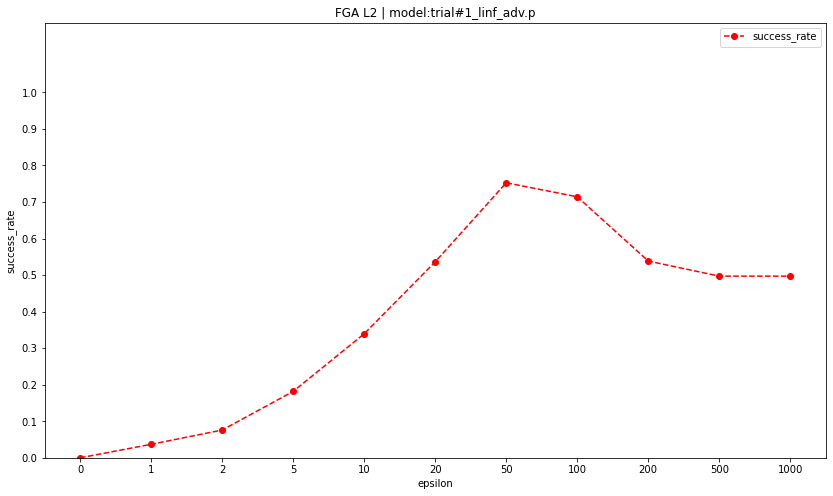

  0%|          | 0/27 [00:00<?, ?it/s]

Perform Attack #3/3: FGA L1


  0%|          | 0/27 [00:00<?, ?it/s].85s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 100}
Early stopping: 	False (-1)

Successfully attacked:	19
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.01
Perturbed Accurracy: 	0.81


  0%|          | 0/27 [00:00<?, ?it/s].87s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 200}
Early stopping: 	False (-1)

Successfully attacked:	48
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.03
Perturbed Accurracy: 	0.79


  0%|          | 0/27 [00:00<?, ?it/s].89s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 500}
Early stopping: 	False (-1)

Successfully attacked:	118
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.09
Perturbed Accurracy: 	0.75


  0%|          | 0/27 [00:00<?, ?it/s].91s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 1000}
Early stopping: 	False (-1)

Successfully attacked:	236
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.17
Perturbed Accurracy: 	0.68


  0%|          | 0/27 [00:00<?, ?it/s].94s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 2000}
Early stopping: 	False (-1)

Successfully attacked:	441
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.32
Perturbed Accurracy: 	0.56


  0%|          | 0/27 [00:00<?, ?it/s].93s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 5000}
Early stopping: 	False (-1)

Successfully attacked:	805
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.58
Perturbed Accurracy: 	0.34


  0%|          | 0/27 [00:00<?, ?it/s].97s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 10000.0}
Early stopping: 	False (-1)

Successfully attacked:	1032
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.75
Perturbed Accurracy: 	0.21


  0%|          | 0/27 [00:00<?, ?it/s].98s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 20000.0}
Early stopping: 	False (-1)

Successfully attacked:	1000
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.72
Perturbed Accurracy: 	0.23


  0%|          | 0/27 [00:00<?, ?it/s].99s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 50000.0}
Early stopping: 	False (-1)

Successfully attacked:	720
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.52
Perturbed Accurracy: 	0.39


100%|██████████| 10/10 [00:39<00:00,  3.96s/it]

Attack-Parameters:	{'norm': '1', 'epsilon': 100000.0}
Early stopping: 	False (-1)

Successfully attacked:	687
Total attacked: 	1382
Total processed:	1687

Success-Rate: 		0.5
Perturbed Accurracy: 	0.41


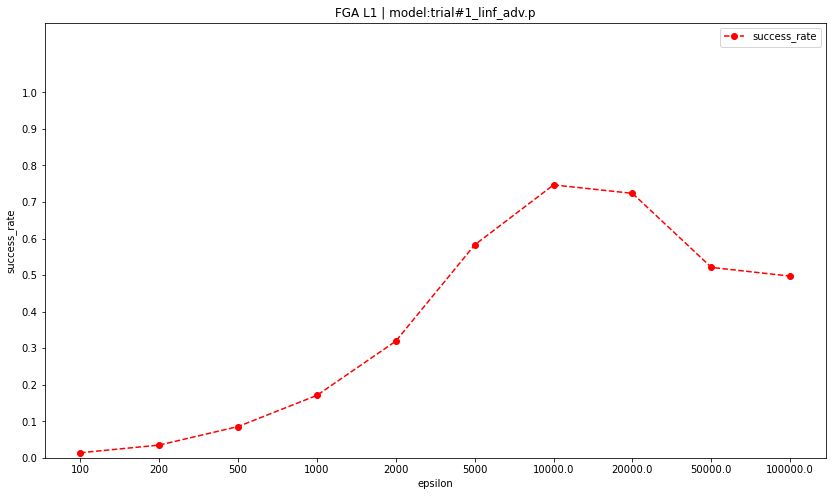

In [167]:
experiment.run("./adv_training_results/trial#1_linf_adv.p", M5PLModule)